<a href="https://colab.research.google.com/github/blancavazquez/diplomado_IA/blob/main/notebooks/Tema_02/05_Retropropagacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulo 11: Introducción a las redes neuronales
# Tema 2: Redes densas
## Algoritmo de retropropagación de errores

El objetivo de esta libreta es construir una red neuronal densa y entrenarla en un problema de clasificación usando el algoritmo de retropropagación de errores

## Paso 1: Carga de bibliotecas

In [1]:
import numpy as np
from math import floor

## Paso 2: Construcción de la arquitectura de la red neuronal densa


La red neuronal densa que vamos a construir está compuesta de los siguiente elementos:
1. Una capa de entrada con 2 variables $x_1$ y $x_2$.
2. Una capa oculta con 5 neuronas, donde cada neurona tiene una función de activación sigmoide.
3. Una capa de salida con una sola neurona con una función de activación sigmoide.

### 2.1 Construcción de la función de propagación hacia adelante
Se define la función que propaga hacia adelante una entrada $\mathbf{X} \in \mathbb{R}^{m \times d}$. dado que la red está compuesta de 2 capas densas (1 oculta y 1 de salida), tenemos 2 matrices de pesos con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}} \in \mathbb{R}^{d \times l}, \mathbf{b}^{\{1\}} \in \mathbb{R}^{l \times 1}\}$ y $\{\mathbf{W}^{\{2\}} \in \mathbb{R}^{l \times k}, \mathbf{b}^{\{2\}} \in \mathbb{R}^{k \times 1}\}$ de la capa oculta y la capa de salida respectivamente. Así, podemos llevar a cabo la propagación hacia adelante en esta red de la siguiente manera:

$$
	\begin{split}
				\mathbf{A}^{\{1\}} & =  \mathbf{X} \\
				\mathbf{Z}^{\{2\}} & =  \mathbf{A}^{\{1\}} \cdot \mathbf{W}^{\{1\}} + \mathbf{b}^{\{1\}}\\
				\mathbf{A}^{\{2\}} & =  \sigma(\mathbf{Z}^{\{2\}}) \\
				\mathbf{Z}^{\{3\}} & =  \mathbf{A}^{\{2\}} \mathbf{W}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
				\mathbf{A}^{\{3\}} & =  \sigma(\mathbf{Z}^{\{3\}})\\
				\mathbf{\hat{y}} & =  \mathbf{A}^{\{3\}}
		\end{split}
  $$

In [2]:
def propagacion_adelante(X, W1, b1, W2, b2):
  #Función que calcula la propagación hacia adelante de la red neuronal densa.
  Z2 = X @ W1 + b1 #Capa 2
  A2 = sigmoide(Z2) #Salida de la capa 2
  Z3 = A2 @ W2 + b2 #Capa 3
  y_hat = sigmoide(Z3) #Salida de la capa 3
  return Z2, A2, Z3, y_hat

### 2.2 Construcción de la función de retropropagación

Se define la función de descenso del gradiente por retropropagación de errores. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa se utiliza el algoritmo de retropropagación. Para nuestro caso, serían las siguientes expresiones:

$$
	\begin{split}
				\boldsymbol{\delta}^{\{3\}} & =  \mathbf{\hat{y}}^{(i)} - \mathbf{y}^{(i)}\\
				\frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{2\}}} & =  \mathbf{A}^{\{2\}\top} \cdot \boldsymbol{\delta}^{\{3\}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{2\}}} & =  \sum_{j=1}^{k}\boldsymbol{\delta}^{\{3\}}_{j, :}\\
        \boldsymbol{\delta}^{\{2\}} & =  (\boldsymbol{\delta}^{\{3\}}\cdot \mathbf{W}^{\{2\}\top}) \odot \frac{\partial \mathbf{A}^{\{2\}}}{\partial \mathbf{Z}^{\{2\}}}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{b}^{\{1\}}} & =  \sum_{j=1}^{l}\boldsymbol{\delta}^{\{2\}}_{j, :}\\
        \frac{\partial ECB(\mathbf{y}, \mathbf{\hat{y}})}{\partial \mathbf{W}^{\{1\}}} & =  \mathbf{A}^{\{1\}\top} \cdot \boldsymbol{\delta}^{\{2\}}\\
		\end{split}
  $$

In [3]:

def retropropagacion(X, y, lr = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10):
  #Función para entrenar nuestra red neuronal densa usando descenso por gradiente.

  n_ejemplos = X.shape[0] #número de registros / muestras en los datos
  n_entradas = X.shape[1] #número de variables de entrada en la 1ra capa.
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices:
  #Las matrices W1 y W2 se inicializan con valores pequeños
  # Mientras que las matrices de b1 y b2 se inicializan con valores de 0s.
  W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
  b1 = np.zeros((1, n_ocultas))

  W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
  b2 = np.zeros((1, 1))

  #Creación de las matrices para guardar resultados
  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))

  #El algoritmo se ejecutará hasta alcanzar el número de épocas.
  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote): #generar lotes de datos
      Z2, A2, Z3, y_hat = propagacion_adelante(Xlote, W1, b1, W2, b2) #se ejecuta la propagación hacia adelante

      # cálculo de gradientes para W2 y b2 por retropropagación
      dZ3 = y_hat - ylote
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      dZ2 = (dZ3 @ W2.T) * derivada_sigmoide(Z2) #cálculo de la derivada
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # Actualización de parámetros
      # la actualización debe realizarse de forma simultánea
      W2 -= lr * dW2
      b2 -= lr * db2
      W1 -= lr * dW1
      b1 -= lr * db1

      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria(ylote, y_hat)  #Función de pérdida
      exactitudes[i] += exactitud(ylote, np.round(y_hat)) #cálculo de la exactitud (accuracy, en inglés)

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, perdidas, exactitudes

Se construye una función para generar lotes de los datos de forma aleatoria

In [4]:
def genera_lotes(X, y, t_lote=16):
  #Función que genera lotes del conjunto de entrenamiento (batch)
  #Los lotes se genera de forma aleatoria
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  perm = np.random.permutation(X.shape[0]) # se genera una permutación aleatoria
  Xperm = X[perm] # se reordenan las entradas y
  yperm = y[perm] # las entradas usando la permutación
  for lote in range(n_lotes): # se tomando t_lote entradas y salidas
    Xlote = Xperm[lote * t_lote:(lote + 1) * t_lote]
    ylote = yperm[lote * t_lote:(lote + 1) * t_lote]
    yield Xlote, ylote

Definición de la función de activación sigmoide

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [5]:
def sigmoide(z):
  #Función que calcula la sigmoide
  return 1 / (1 + np.exp(-z))

La función sigmoide tiene una derivada que está expresada en términos de la misma función, esto es,

$$
\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))
$$

In [6]:
def derivada_sigmoide(x):
  #Función que calcula la deriva de la sigmoide
  s = sigmoide(x)
  return s * (1.0 - s)

Dado que nuestro problema es de tipo clasificación binaria, entonces, para calcular la pérdida se usará la entropía cruzada binaria:

$$
ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]
$$

In [7]:
def entropia_cruzada_binaria(y, p):
  #Función para calcular la entropía cruzada binaria
  p[p == 0] = np.nextafter(0., 1.)
  p[p == 1] = np.nextafter(1., 0.)
  return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

Para medir el rendimiento del modelo, se calculará la exactitud

$$
exactitud = \frac{correctos}{total}
$$

In [8]:
def exactitud(y, y_predicha):
  #Función para calcular la exactitud del modeo
  return (y == y_predicha).mean() * 100

¿Y si inicializamos con ceros?

Las matrices de pesos $\mathbf{W^{\{1\}}}$ y $\mathbf{W^{\{2\}}}$ se initializan con valores aleatorios pequeños mientras que los vectores de sesgo $\mathbf{b^{\{1\}}}$ y $\mathbf{b^{\{1\}}}$ con zeros. Examinemos qué pasa si inicializamos las matrices de pesos con zeros. Observa los valores de los pesos en cada época.

In [9]:
def retropropagacion_zeros(X, y, lr = 0.01, t_lote=16, n_epocas = 100, n_ocultas = 10):
  #Función para entrenar nuestra red neuronal densa usando descenso por gradiente
  #Inicializando las matrices de pesos con 0s.

  n_ejemplos = X.shape[0] #número de registros / muestras en los datos
  n_entradas = X.shape[1] #número de variables de entrada en la 1ra capa.
  n_lotes = floor(X.shape[0] / t_lote) # se calcula el número de lotes (si el
                                       # tamaño del último lote < t_lote se
                                       # ignora

  # Inicialización de las matrices de pesos W y V
  W1 = np.zeros((n_entradas, n_ocultas))
  b1 = np.zeros((1, n_ocultas))

  W2 = np.zeros((n_ocultas, 1))
  b2 = np.zeros((1, 1))

   #Creación de las matrices para guardar resultados
  perdidas = np.zeros((n_epocas))
  exactitudes = np.zeros((n_epocas))
  y_predicha = np.zeros((y.shape))

  #El algoritmo se ejecutará hasta alcanzar el número de épocas.
  for i in range(n_epocas):
    for Xlote,ylote in genera_lotes(X, y, t_lote=t_lote): #generar lotes de datos
      Z2, A2, Z3, y_hat = propagacion_adelante(Xlote, W1, b1, W2, b2) #se ejecuta la propagación hacia adelante

      # cálculo de gradientes para W2 y b2 por retropropagación
      dZ3 = y_hat - ylote
      dW2 = A2.T @ dZ3
      db2 = dZ3.sum(axis=0)

      # cálculo de gradientes para W1 y b1 por retropropagación
      dZ2 = (dZ3 @ W2.T) * derivada_sigmoide(Z2)
      dW1 = Xlote.T @ dZ2
      db1 = dZ2.sum(axis=0)

      ####################################
      # Actualización de parámetros
      # la actualización debe realizarse de forma simultánea
      W2 -= lr * dW2
      b2 -= lr * db2
      W1 -= lr * dW1
      b1 -= lr * db1

      # calcula la pérdida en la época
      perdidas[i] += entropia_cruzada_binaria(ylote, y_hat)  #Función de pérdida
      exactitudes[i] += exactitud(ylote, np.round(y_hat)) #cálculo de la exactitud (accuracy, en inglés)

    perdidas[i] /= n_lotes
    exactitudes[i] /= n_lotes
    print(f'Epoch {i}: Pérdida = {perdidas[i]} Exactitud = {exactitudes[i]}')

  return W1, b1, W2, b2, perdidas, exactitudes

## Paso 3: Entrenamiento de la red

In [45]:
#Generamos datos sintéticos
from sklearn.datasets import make_classification # Usamos la función de make_classification de sklearn.
num_clases = 2 #Número de clases de los datos a generar

#Generación de datos
X, y = make_classification(n_samples = 10000, #número de datos a generar
                           n_features=2,
                           n_redundant=0,
                           n_informative=2,
                           n_clusters_per_class=1,
                           class_sep=5)

In [47]:
#Entrenamiento
np.random.seed(42) #
W1, b1, W2, b2, perdidas, exactitudes = retropropagacion(X,
                                                         y,
                                                         lr = 0.5, #tasa de aprendizaje
                                                         n_epocas = 10, #Número de épocas
                                                         n_ocultas = 5, #Número de neuronas en la capa oculta
                                                         t_lote=1)

Epoch 0: Pérdida = 0.029346743395253286 Exactitud = 99.57
Epoch 1: Pérdida = 0.028092543702453322 Exactitud = 99.59
Epoch 2: Pérdida = 0.027549143611315417 Exactitud = 99.58
Epoch 3: Pérdida = 0.028565057590592396 Exactitud = 99.59
Epoch 4: Pérdida = 0.028684433772350963 Exactitud = 99.59
Epoch 5: Pérdida = 0.028060275108906404 Exactitud = 99.59
Epoch 6: Pérdida = 0.028401700397978208 Exactitud = 99.59
Epoch 7: Pérdida = 0.028898990091846214 Exactitud = 99.59
Epoch 8: Pérdida = 0.028349637234843003 Exactitud = 99.59
Epoch 9: Pérdida = 0.02850822969935979 Exactitud = 99.59


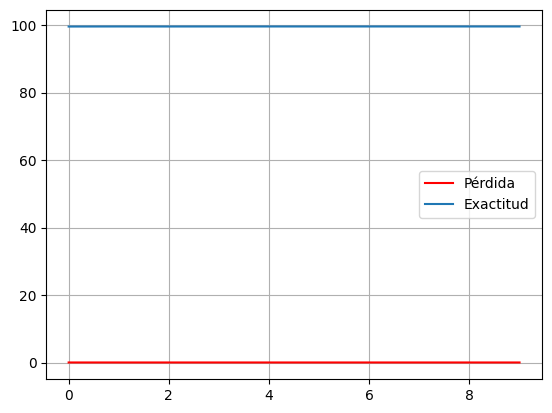

In [48]:
#Se grafica la pérdida y exactitud obtenidos durante el entrenamiento
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas.size), perdidas, label='Pérdida', c = 'r')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

¿Qué pasa si inicializamos los pesos con ceros.

In [49]:
np.random.seed(42)
W1, b1, W2, b2, perdidas, exactitudes = retropropagacion_zeros(X,
                                                               y,
                                                               lr = 0.5,
                                                               n_epocas = 50,
                                                               n_ocultas = 5,
                                                               t_lote=1)

Epoch 0: Pérdida = 0.03034683721238643 Exactitud = 99.54
Epoch 1: Pérdida = 0.027900543973415903 Exactitud = 99.59
Epoch 2: Pérdida = 0.028064356866586065 Exactitud = 99.59
Epoch 3: Pérdida = 0.028757019055592074 Exactitud = 99.59
Epoch 4: Pérdida = 0.028347966918093822 Exactitud = 99.59
Epoch 5: Pérdida = 0.02787534348136928 Exactitud = 99.59
Epoch 6: Pérdida = 0.028111560377047373 Exactitud = 99.59
Epoch 7: Pérdida = 0.028453495466478785 Exactitud = 99.59
Epoch 8: Pérdida = 0.027867759421635236 Exactitud = 99.59
Epoch 9: Pérdida = 0.02823871708076226 Exactitud = 99.59
Epoch 10: Pérdida = 0.02814335451610483 Exactitud = 99.59
Epoch 11: Pérdida = 0.02810650216718874 Exactitud = 99.59
Epoch 12: Pérdida = 0.027680779687411165 Exactitud = 99.59
Epoch 13: Pérdida = 0.027963547487129977 Exactitud = 99.59
Epoch 14: Pérdida = 0.028107591385195765 Exactitud = 99.59
Epoch 15: Pérdida = 0.028155611124117103 Exactitud = 99.59
Epoch 16: Pérdida = 0.02810714393557737 Exactitud = 99.59
Epoch 17: Pér

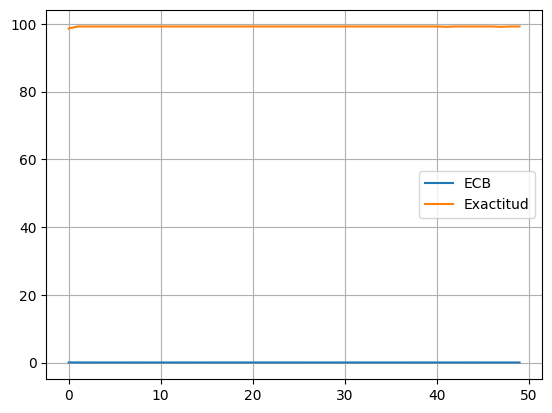

In [36]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

### Ejercicio: Clasificación binaria

Construye un clasificador no lineal con los siguientes requerimientos:

1. Genera datos sintéticos (usando funciones de numpy) o utiliza alguna base de datos conocida.

2. Genera un par de gráficas de análisis de datos (en caso de que los datos sean usando alguna base de datos).

3. Divide tus datos en: entrenamiento y prueba (80-20).

4. El clasificador debe ser entrendo con la función de retropropagación definida previamente. Prueba con difentes tasas de aprendizaje

5. Grafica la pérdida y exactitud obtenidos durante el entrenamiento

6. Evalúa el desempeño de tu modelo en tus datos de prueba.